# Mexico Antenna exploration and processing
La idea es

* Catalogar antenas por sus provincias 
* Graficar el mapa de Mexico con sus antennas
* limpiar aquellas que caigan "al agua"
* Catalogar las antenas como pertenecientes o no a regiones del *"Gran Chaco"* mejicano
* dibujar el mapa epidmeico

## definicion utilizada

In [1]:
import pandas as pd; import numpy as np; import os;import random;
pd.set_option('display.max_rows', 300)
from matplotlib import pyplot as plt
%matplotlib inline
import unicodedata
import gzip

import geopandas as gpd;
from geopandas.geoseries import *
import shapely

rootdir=os.getcwd()
rootdir = os.path.expanduser('~/Repositories/Tesis')
np.random.seed(2015)

In [2]:
global mapa

In [3]:
mapa = gpd.GeoDataFrame.from_file(rootdir+'/mapas/national_estatal.geojson')

In [4]:
mapa[mapa['NOMBRE']==u'Chiapas']

,CVEGEO,NOMBRE,OID,POB1,POB10,POB10_R,POB11,POB11_R,POB12,POB12_R,...,POB7_R,POB8,POB80,POB80_R,POB81,POB81_R,POB8_R,POB9,POB9_R,geometry
6,07,Chiapas,7,4796580,968252,20.2,1334789,27.8,2860151,59.6,...,6.9,1645047,116587,5.0,78285,3.3,34.3,326491,6.8,POLYGON ((-91.97363681088724 17.91143118947898...


In [5]:
antenas = pd.read_csv("surrogated_antennas.txt.gz",
                      sep=" ",
                     header=0,
                     index_col=0)
#paso lat y long a su forma decimal
antenas['LATITUDE']=antenas['LATITUDE']*1.0/1000
antenas['LONGITUDE']=antenas['LONGITUDE']*1.0/1000

#chequeo resultados rapido
antenas.sample(100)

,LATITUDE,LONGITUDE
ID,,
2692,25.923,-98.711
1629,19.058,-98.212
3741,16.884,-99.838
1437,20.655,-105.214
1867,19.519,-99.034
2259,17.664,-101.612
1677,19.534,-98.868
1462,19.430,-99.092
152,19.796,-99.872


In [6]:
#chequeo si hay info faltante
antenas[pd.isnull(antenas).any(axis=1)]

,LATITUDE,LONGITUDE
ID,,


In [7]:
#chequeo que no haya antenas repetidas
len(np.unique(antenas.index.values))==len(antenas.index.values)

True

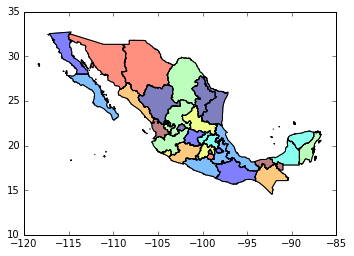

In [8]:
mapa.plot()

# Muy importante!
 
Las coordenadas en un mapa se dan en (lat, long) que no corresponden a las coordenadas cartesianas sino a (y,x) con lo cual es importante armar los **Point** con (long,lat), sino imposible comprarar quien esta dentro de que..

In [9]:
subset =  antenas[['LONGITUDE','LATITUDE']]
tuples = [shapely.geometry.Point(x) for x in subset.values] 
global antenas_gpd 
antenas_gpd =  gpd.GeoSeries(tuples)
antenas_gpd.index = antenas.index

In [10]:
multipoligono = mapa['geometry'].ix[6]
multipoligono.contains(antenas_gpd.ix[2])

False

In [11]:
def preparar_nombre(s):
        #esta linea elimina las tildes espacios puntos y similar"
        sin_tilde = ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))
        limpio = sin_tilde.replace(" ","_").replace(".","")
        #me quedo con el nombre corto de Veracruz
        if limpio == u'Veracruz_de_Ignacio_de_la_Llave':
            limpio = u'Veracruz'
        return limpio

In [12]:
mapa['NOMBRE'] = mapa['NOMBRE'].apply(lambda s: preparar_nombre(s))

In [13]:
def get_state_name(ant,lista_de_geometrias,lista_de_nombres):
        sol ="Error";
        for i in range(len(lista_de_geometrias)):
            if lista_de_geometrias.ix[i].contains(ant):
                sol = lista_de_nombres[i]
                break
        return sol

In [14]:
%%time 
antenas_gpd.ix[1:100].apply(lambda ant: get_state_name(ant, mapa['geometry'],mapa.NOMBRE.values))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 793 µs


Series([], dtype: object)

In [15]:
antenas.head()

,LATITUDE,LONGITUDE
ID,,
2797,14.671,-92.372
3060,14.682,-92.155
3344,14.721,-92.424
3487,14.778,-92.179
1924,14.786,-92.366


In [16]:
antenas_gpd.head()

ID
2797               POINT (-92.372 14.671)
3060               POINT (-92.155 14.682)
3344    POINT (-92.42400000000001 14.721)
3487               POINT (-92.179 14.778)
1924               POINT (-92.366 14.786)
dtype: object

In [17]:
%%time
antenas['STATE'] = antenas_gpd.apply(lambda ant: get_state_name(ant, mapa['geometry'],mapa.NOMBRE.values))

CPU times: user 33.9 s, sys: 8 ms, total: 33.9 s
Wall time: 34 s


In [18]:
#miro aquellas que no pude hacerlo sistematicamente y veo si las elimino o las "corro"
antenas[antenas['STATE']=="Error"]

,LATITUDE,LONGITUDE,STATE
ID,,,
2614,21.183,-86.807,Error
4293,23.005,-109.714,Error
1974,23.258,-106.463,Error


In [70]:
antenas['STATE'].unique()

array([u'Chiapas', u'Oaxaca', u'Guerrero', u'Tabasco', u'Veracruz',
       u'Michoacan_de_Ocampo', u'Puebla', u'Morelos', u'Quintana_Roo',
       u'Campeche', u'Mexico', u'Colima', u'Tlaxcala', u'Distrito_Federal',
       u'Jalisco', u'Hidalgo', u'Guanajuato', u'Queretaro', u'Yucatan',
       u'Nayarit', 'Error', u'Aguascalientes', u'San_Luis_Potosi',
       u'Tamaulipas', u'Zacatecas', u'Sinaloa', u'Baja_California_Sur',
       u'Durango', u'Nuevo_Leon', u'Coahuila_de_Zaragoza', u'Sonora',
       u'Chihuahua', u'Baja_California'], dtype=object)

In [71]:
antenas.at[antenas['STATE']==u'Veracruz_de_Ignacio_de_la_Llave','STATE']=u'Veracruz'

In [72]:
antenas.at[2614,'LONGITUDE']

-86.807000000000002

In [73]:
#asigno a mano aquellas que me habin quedado un toque afuera
antenas.at[2614,'LONGITUDE']=-86.857
antenas.at[2614,'STATE']=u'Quintana_Roo'
antenas.at[4293,'LATITUDE']=23.055
antenas.at[4293,'STATE']=u'Baja_California_Sur'
antenas.at[1974,'LONGITUDE']=-106.403
antenas.at[1974,'STATE']=u'Sinaloa'

In [75]:
antenas.loc[2614]

LATITUDE           21.183
LONGITUDE         -86.857
STATE        Quintana_Roo
Name: 2614, dtype: object

In [74]:
#chequeo nuevamente
antenas[antenas['STATE']=="Error"]

,LATITUDE,LONGITUDE,STATE
ID,,,


## Ahora vemos cuales son del Gran Chaco

recordar que estas son las que estan en los estados de Jalisco, Oaxaca, Veracruz, Guerrero,Morelos, Yucatan, Queretaro, Chiapas, Puebla, Nayarit, Hidalgo y Tabasco.

In [76]:
def get_epidemic_state(estado):
    sol=0 
    epidemic_states =  [u'Jalisco', u'Oaxaca', u'Puebla',u'Veracruz', u'Guerrero',u'Morelos',
                     u'Tabasco',u'Hidalgo']
    if estado in epidemic_states:
        sol =1
    return sol    

In [77]:
antenas['EPIDEMIC']=antenas['STATE'].apply(lambda k: get_epidemic_state(k))

In [79]:
antenas.sample(30)

,LATITUDE,LONGITUDE,STATE,EPIDEMIC
ID,,,,
1652,19.511,-99.085,Mexico,0
2244,19.266,-99.173,Distrito_Federal,0
4251,19.387,-99.252,Distrito_Federal,0
2913,20.623,-103.057,Jalisco,1
2364,19.350,-99.037,Distrito_Federal,0
1380,19.403,-99.154,Distrito_Federal,0
304,19.263,-99.646,Mexico,0
3463,21.878,-102.304,Aguascalientes,0
974,16.256,-92.146,Chiapas,0


In [80]:
antenas.EPIDEMIC.sum()

1075

In [81]:
len(antenas),antenas.EPIDEMIC.sum(),antenas.EPIDEMIC.sum()*1.0/len(antenas)

(4429, 1075, 0.24271844660194175)

In [27]:
fig = plt.figure(figsize=(8,8),dpi=300)

In [82]:
epidemic_states =  [u'Jalisco', u'Oaxaca', u'Puebla',u'Veracruz', u'Guerrero',u'Morelos',
                     u'Tabasco',u'Hidalgo']

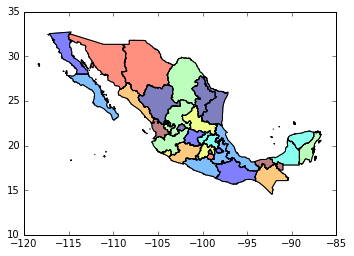

In [23]:
mapa[['geometry','NOMBRE']].plot()
#    .plot(colormap='Accent', alpha=0.7,figsize=(10,10),dpi=300)

In [83]:
antenas.to_csv(rootdir +"/antennas_mexico.csv",index=True,sep="|")

In [24]:
def get_epidemic_state(estado):
    sol=0
    epidemicos = [u'Jalisco', u'Oaxaca', u'Puebla',u'Veracruz', u'Guerrero',u'Morelos',
                     u'Tabasco',u'Hidalgo']
    if estado in epidemicos:
        sol =1
    return sol    

mapa['EPIDEMIC']=mapa['NOMBRE'].apply(lambda k: get_epidemic_state(k))

In [25]:
mapa

,CVEGEO,NOMBRE,OID,POB1,POB10,POB10_R,POB11,POB11_R,POB12,POB12_R,...,POB8,POB80,POB80_R,POB81,POB81_R,POB8_R,POB9,POB9_R,geometry,EPIDEMIC
0,01,Aguascalientes,1,1184996,227733,19.2,321337,27.1,746380,63.0,...,374237,27477,4.8,17582,3.0,31.6,74156,6.3,"POLYGON ((-102.287865181776 22.41649003941674,...",0
1,02,Baja_California,2,3155070,585674,18.6,851102,27.0,2075134,65.8,...,901886,65653,4.1,40567,2.5,28.6,179165,5.7,(POLYGON ((-112.663839812965 28.41882990629272...,0
2,03,Baja_California_Sur,3,637026,116403,18.3,173928,27.3,421998,66.2,...,178472,13323,4.1,8098,2.5,28.0,34715,5.4,(POLYGON ((-109.8946081395473 22.8748229076171...,0
3,04,Campeche,4,822441,159308,19.4,227505,27.7,533014,64.8,...,236538,23517,5.8,15922,3.9,28.8,50917,6.2,"(POLYGON ((-90.379356996781 20.84832728852915,...",0
4,05,Coahuila_de_Zaragoza,5,2748391,492074,17.9,702310,25.6,1756839,63.9,...,797175,73690,5.4,46863,3.4,29.0,160612,5.8,POLYGON ((-102.3107926469074 29.87694857356026...,0
5,06,Colima,6,650555,122393,18.8,175529,27.0,424730,65.3,...,177605,19284,6.0,12519,3.9,27.3,37542,5.8,(POLYGON ((-114.7264985875087 18.3603718880001...,0
6,07,Chiapas,7,4796580,968252,20.2,1334789,27.8,2860151,59.6,...,1645047,116587,5.0,78285,3.3,34.3,326491,6.8,POLYGON ((-91.97363681088724 17.91143118947898...,0
7,08,Chihuahua,8,3406465,607906,17.8,862942,25.3,2127341,62.5,...,982401,91391,5.4,58580,3.5,28.8,194548,5.7,POLYGON ((-107.6565846965906 31.78370480565208...,0
8,09,Distrito_Federal,9,8851080,1476776,16.7,2203472,24.9,6027661,68.1,...,1937538,282544,6.7,182634,4.3,21.9,426210,4.8,POLYGON ((-99.11124114247357 19.56149777358792...,0
9,10,Durango,10,1632934,309743,19.0,427457,26.2,1003805,61.5,...,495733,51204,6.4,34256,4.3,30.4,101362,6.2,POLYGON ((-105.9673160290395 26.78553654945048...,0


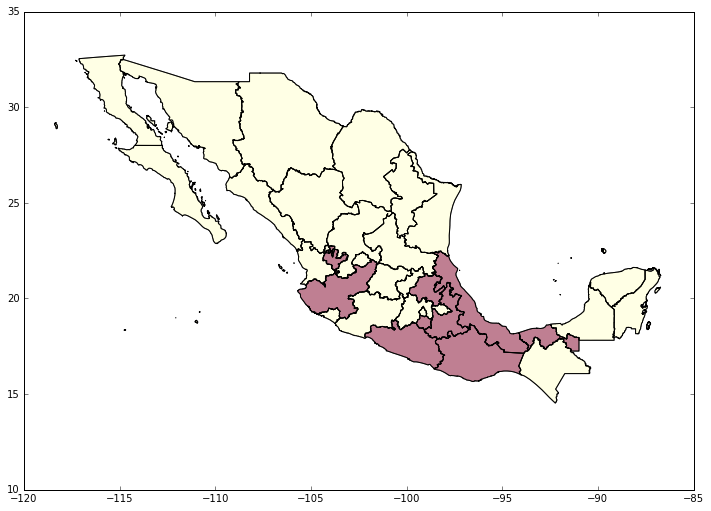

In [33]:
fig = plt.figure(figsize=(12,12),dpi=300)
kw = dict(column="EPIDEMIC",k=6,colormap='YlOrRd')
mapa.plot(scheme = "Quantiles",**kw)